<a href="https://colab.research.google.com/github/chaos44/signate_competition/blob/main/off_road.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/chaos44/signate_competition

Cloning into 'signate_competition'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 101 (delta 20), reused 7 (delta 1), pack-reused 0
Receiving objects: 100% (101/101), 51.89 MiB | 15.59 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [ ]:
cd signate_competition

/content/signate_competition


In [ ]:
ls

ames.ipynb         ames_kaggle_scaled.ipynb  off_road/
ames_kaggle.ipynb  ams_beginner/             README.md


In [ ]:
import os
from glob import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']
from PIL import Image
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms

print(torch.__version__)
print(torch.cuda.is_available())

# 評価対象カテゴリ
eval_names = ('road','dirt road', 'other obstacle')
eval_colors = ((128, 64, 128), (255, 128, 128), (0, 0, 70))

1.7.0+cu101
False


## **1. データの読み込み**

データの読み込みを行います。
まずは「学習用画像」「学習用アノテーション」「精度評価用画像」のファイルパスをそれぞれ取得しましょう。

In [ ]:
train_images_path_list = sorted(glob('off_road/train_images_A/*.png'))
train_annotations_path_list = sorted(glob('off_road/train_annotations_A/*.png'))
precision_test_images_path_list = sorted(glob('off_road/precision_test_images/*.png'))

print('================')
print('学習用画像: ')
print(len(train_images_path_list))
print(train_images_path_list[:5])
print('================')
print('学習用アノテーション: ')
print(len(train_annotations_path_list))
print(train_annotations_path_list[:5])
print('================')
print('精度評価用画像: ')
print(len(precision_test_images_path_list))
print(precision_test_images_path_list[:5])

学習用画像: 
10
['off_road/train_images_A/train_image_A0000.png', 'off_road/train_images_A/train_image_A0001.png', 'off_road/train_images_A/train_image_A0002.png', 'off_road/train_images_A/train_image_A0003.png', 'off_road/train_images_A/train_image_A0004.png']
学習用アノテーション: 
10
['off_road/train_annotations_A/train_annotation_A0000.png', 'off_road/train_annotations_A/train_annotation_A0001.png', 'off_road/train_annotations_A/train_annotation_A0002.png', 'off_road/train_annotations_A/train_annotation_A0003.png', 'off_road/train_annotations_A/train_annotation_A0004.png']
精度評価用画像: 
10
['off_road/precision_test_images/precision_test_image_0010.png', 'off_road/precision_test_images/precision_test_image_0011.png', 'off_road/precision_test_images/precision_test_image_0012.png', 'off_road/precision_test_images/precision_test_image_0013.png', 'off_road/precision_test_images/precision_test_image_0014.png']


学習用データは、「画像」・「アノテーション」ともに10枚、
精度評価用の画像は10枚存在することを確認しました。

画像データの可視化

画像データの可視化を実行します。
上で取得したファイルパスを用いて画像データを読み込み、互いに対応する「画像」と「アノテーション」を横に並べて可視化してみましょう。


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


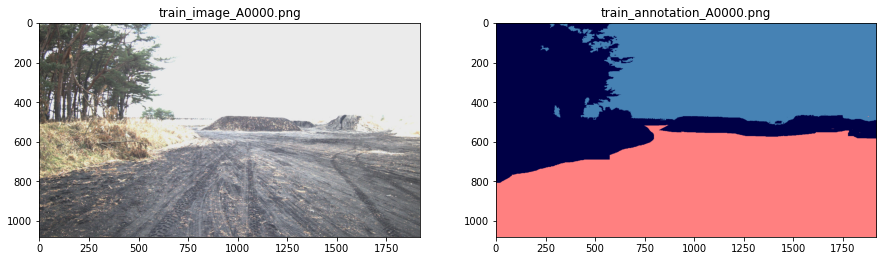

In [ ]:
# 画像の読み込み
image_0000 = Image.open('off_road/train_images_A/train_image_A0000.png')
annotation_0000 = Image.open('off_road/train_annotations_A/train_annotation_A0000.png')

# 可視化
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

axes[0].imshow(image_0000)
axes[0].set_title('train_image_A0000.png')

axes[1].imshow(annotation_0000)
axes[1].set_title('train_annotation_A0000.png')

plt.show()

各評価対象カテゴリが含まれる画像枚数の確認

各評価対象カテゴリに該当する物体(road, dirt road, other obstacle)は、全ての画像内に登場するとは限りません。
各カテゴリの物体が各画像にどれほどの頻度で登場しているのかについて、学習用アノテーション画像を対象に確認しましょう。

<BarContainer object of 3 artists>

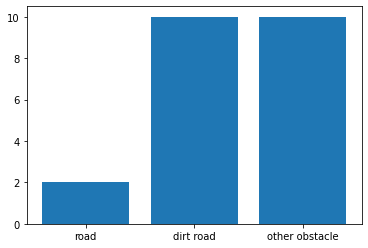

In [ ]:
count = {
    'road': 0,
    'dirt road': 0,
    'other obstacle':0
}

for train_annotation_path in train_annotations_path_list:
    image = np.array(Image.open(train_annotation_path))
    
    for eval_name, eval_color in zip(eval_names, eval_colors):
        mask = (image==eval_color).sum(axis=2)==3
        if np.any(mask):
            count[eval_name] += 1
            
plt.bar(count.keys(), count.values())


## **2. モデリング**

簡易的な手法を用いたモデリングを実施します。

前処理クラスの定義

前処理では、「画像の縮小」「テンソル化」「入力画像の標準化」「アノテーション画像の4カテゴリ表現への変換」などを行います。

In [ ]:
class OffRoadTransform():
    def __init__(self, image_size, mean, std):
        self.image_size = image_size
        self.mean = mean
        self.std = std
        
    def __call__(self, image, annotation):
        
        # リサイズ
        image = image.resize((self.image_size[1], self.image_size[0]))        
        annotation = annotation.resize((self.image_size[1], self.image_size[0]))
        
        # テンソル化&標準化
        image = transforms.functional.to_tensor(image)
        image = transforms.functional.normalize(image, self.mean, self.std)
        
        # アノテーション画像の色(RGB)情報を以下のように対応するようマッピングし、2次元の配列に変換する
        """
        road(128, 64, 128) -> 1
        dirt road(255, 128, 128) -> 2
        other obstacle(0, 0, 70) -> 3
        上記以外 -> 0
        """
        annotation = np.array(annotation)
        converted_annotation = np.zeros(annotation.shape[:-1])
        for i, eval_color in enumerate(eval_colors):
            mask = (annotation==eval_color).sum(axis=2)==3
            converted_annotation[mask] = i+1
        annotation = torch.from_numpy(converted_annotation)
        
        return image, annotation


データセットの作成

torch.utils.data.Datasetクラスを継承したクラスを作成します。


In [ ]:
class OffRoadDataset(data.Dataset):
    def __init__(self, image_list, annotation_list, transform):
        self.image_list = image_list
        self.annotation_list = annotation_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):

        image_filepath = self.image_list[index]
        annotation_filepath = self.annotation_list[index]
        
        image = Image.open(image_filepath)
        annotation = Image.open(annotation_filepath)

        image, annotation = self.transform(image, annotation)
        
        return image, annotation

In [ ]:
train_dataset = OffRoadDataset(train_images_path_list, train_annotations_path_list,
                              transform=OffRoadTransform(image_size=(270, 480), mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)))

print(train_dataset.__getitem__(0)[0].shape)
print(train_dataset.__getitem__(0)[1].shape)

torch.Size([3, 270, 480])
torch.Size([270, 480])


 **データローダーの作成**

In [ ]:
batch_size = 8
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

**モデルの初期化**

モデルの初期化を行います。
ここでは、torchvisionライブラリに標準で実装されているdeeplabv3_resnet101モデルを使用します。
